In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from typing import Generator, Tuple
from sklearn.preprocessing import MinMaxScaler

#FUNCIONES PROPIAS

In [ ]:
def accuracy(matriz_conf:np.ndarray)->float:
  """
  Toma una matriz de confusión y devuelve la accuracy.
  PARÁMETROS:
  matriz_conf: np.array
    Matriz de confusión.
  RETURN:
  accuracy: float

  """
  return np.trace(matriz_conf)/np.sum(matriz_conf)

In [ ]:
def recall(matriz_conf:np.ndarray)->float:
  """
  Toma una matriz de confusión y devuelve el recall.
  PARÁMETROS:
  matriz_conf: np.array
    Matriz de confusión.
  RETURN:
  recall: float
  """
  tp = matriz_conf[1,1]
  fn = matriz_conf[1,0]
  return tp/(tp+fn)

In [ ]:
def precision(matriz_conf:np.ndarray)->float:
  """
  Toma una matriz de confusión y devuelve la precisión.
  PARÁMETROS:
  matriz_conf: np.array
    Matriz de confusión.
  RETURN:
  precision: float
  """
  tp = matriz_conf[1,1]
  fp = matriz_conf[0,1]
  return tp/(tp+fp) if (tp + fp) > 0 else 0

In [ ]:
def especifidad(matriz_conf:np.ndarray)->float:
  """
  Toma una matriz de confusión y devuelve la especifidad.
  PARÁMETROS:
  matriz_conf: np.array
    Matriz de confusión.
  RETURN:
  especifidad: float
  """
  tn = matriz_conf[0,0]
  fp = matriz_conf[0,1]
  return tn/(tn+fp)

In [ ]:
def skfold_manual(y:pd.DataFrame, k:int=10, random_state:int=42)-> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
    """
    Implementa stratified K-Fold Cross validation en el df de clases "y"
    PARÁMETROS:
    - y: dataframe de clases
    - k: Número de folds.
    - random_state: Valor para replicabilidad
    """
    rng = np.random.default_rng(random_state)
    indices = np.arange(len(y))
    folds = [[] for _ in range(k)]
    for clase in np.unique(y):
        idxs_clase = indices[y == clase]
        rng.shuffle(idxs_clase)
        for i, idx in enumerate(idxs_clase):
            folds[i % k].append(idx)
    for i in range(k):
        test_idx = np.array(folds[i])
        train_idx = np.array([idx for j, fold in enumerate(folds) if j != i for idx in fold])
        yield train_idx, test_idx


#SECCIÓN 1:
## Tratamiento de datos

In [ ]:
datos = pd.read_csv('parkinsons_data.csv').astype(float)
datos.head(10)

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status
0,1.0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654,1.0
1,2.0,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674,1.0
2,3.0,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634,1.0
3,4.0,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975,1.0
4,5.0,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335,1.0
5,6.0,120.552,131.162,113.787,0.00968,0.00008,0.00463,0.00750,0.01388,0.04701,...,0.06985,0.01222,21.378,0.415564,0.825069,-4.242867,0.299111,2.187560,0.357775,1.0
6,7.0,120.267,137.244,114.820,0.00333,0.00003,0.00155,0.00202,0.00466,0.01608,...,0.02337,0.00607,24.886,0.596040,0.764112,-5.634322,0.257682,1.854785,0.211756,1.0
7,8.0,107.332,113.840,104.315,0.00290,0.00003,0.00144,0.00182,0.00431,0.01567,...,0.02487,0.00344,26.892,0.637420,0.763262,-6.167603,0.183721,2.064693,0.163755,1.0
8,9.0,95.730,132.068,91.754,0.00551,0.00006,0.00293,0.00332,0.00880,0.02093,...,0.03218,0.01070,21.812,0.615551,0.773587,-5.498678,0.327769,2.322511,0.231571,1.0
9,10.0,95.056,120.103,91.226,0.00532,0.00006,0.00268,0.00332,0.00803,0.02838,...,0.04324,0.01022,21.862,0.547037,0.798463,-5.011879,0.325996,2.432792,0.271362,1.0


status
1.0    147
0.0     48
Name: count, dtype: int64
----En proporción----
status
1.0    0.753846
0.0    0.246154
Name: proportion, dtype: float64


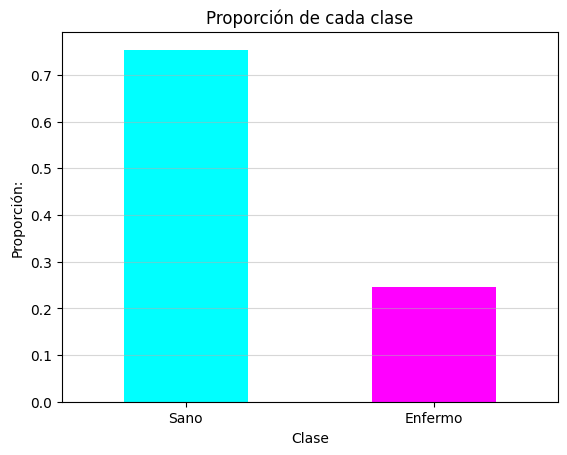

In [ ]:
cantidades = datos["status"].value_counts(normalize = False)
proporciones = datos["status"].value_counts(normalize = True)
print(cantidades)
print("----En proporción----")
print(proporciones)
plt.title("Proporción de cada clase")
proporciones.plot(kind = "bar", color =["cyan", "magenta"])#, label = "Sano")
plt.xlabel("Clase")
plt.ylabel("Proporción:")
plt.xticks(np.arange(2), ["Sano", "Enfermo"], rotation = 0)
#plt.yticks(np.arange(0, 0.8, 0.05))
plt.grid(axis ="y", alpha = 0.5)
plt.show()

La proporción es 75% - 25% por lo que hay desbalanceo moderado

In [ ]:
df = datos.astype(str)

# Fila que contiene al menos un "?" en alguna celda
df_con_interrogacion = df[df.apply(lambda fila: fila.str.contains(r"\?").any(), axis=1)]

# Fila que NO contiene ningún "?" en ninguna celda
df_sin_interrogacion = df[~df.apply(lambda fila: fila.str.contains(r"\?").any(), axis=1)]

print(f"Filas con '?': {len(df_con_interrogacion)}")
print(f"Filas sin '?': {len(df_sin_interrogacion)}")

Filas con '?': 0
Filas sin '?': 195


No hay '?'

#KFOLD

In [ ]:
X = datos.drop(columns=["name", "status"])
y = datos["status"]

def kfoldcross(X:pd.DataFrame, y:pd.DataFrame, random_state:int = 42):
  """
  Hace  KFoldCrossValidation, genera 10 folds, entrena los 5 modelos con cada uno, obtiene métricas y las
  promedia, devuelve 4 arrays con las métricas promedio de cada modelo.

  PARÁMETROS:
  - X: Características
  - y: Objetivo
  - random_state: Valor para replicabilidad
  RETURN:
  - ac_promedios: Métricas de accuracy (shape = (3,))
  - rec_promedios: Métricas de recall (shape = (3,))
  - pres_promedios: Métricas de precisión shape = ((3,))
  - esp_promedios: Métricas de especifidadshape = ((3,))
  """
  accuracys = np.zeros((10, 5))
  recalls = np.zeros((10, 5))
  precisions = np.zeros((10, 5))
  especificidades = np.zeros((10, 5))
  ac_proms = np.zeros(5)
  rec_proms = np.zeros(5)
  pres_proms = np.zeros(5)
  esp_proms = np.zeros(5)
  #skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
  for i, (train_index, test_index) in enumerate(skfold_manual(y, k=10, random_state=random_state)):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #------MODELOS------#

    #MultiLayerPerceptron
      mlp = MLPClassifier(
      hidden_layer_sizes=(100, 50, 25),
      activation='relu',
      learning_rate_init=0.01,
      max_iter=500,
      random_state=random_state,
      verbose=False)
      #KNN
      knn_3 = KNeighborsClassifier(n_neighbors=3, metric = "euclidean")
      knn_5 = KNeighborsClassifier(n_neighbors=5, metric = "euclidean")
      knn_27 = KNeighborsClassifier(n_neighbors=27, metric = "euclidean")

      #Perceptron
      perceptron = MLPClassifier(
        hidden_layer_sizes=(100,),
        activation='tanh',
        learning_rate='adaptive',
        learning_rate_init=0.01,
        max_iter=500,
        random_state=random_state,
        verbose=False)
      modelos = [mlp, perceptron, knn_3, knn_5, knn_27]
      #Entrenamos

      for j, modelo in enumerate(modelos):
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        matriz_conf = confusion_matrix(y_test, y_pred)
        accuracys[i, j] = accuracy(matriz_conf)
        recalls[i, j] = recall(matriz_conf)
        precisions[i, j] = precision(matriz_conf)
        especificidades[i, j] = especifidad(matriz_conf)

  for j in range(5):
    ac_proms[j] = np.mean(accuracys[:, j])
    rec_proms[j] = np.mean(recalls[:, j])
    pres_proms[j] = np.mean(precisions[:, j])
    esp_proms[j] = np.mean(especificidades[:, j])
  return (ac_proms, rec_proms, pres_proms, esp_proms)

In [ ]:
accuracys = np.zeros((30, 5))
recalls = np.zeros((30, 5))
precisions = np.zeros((30, 5))
especificidades = np.zeros((30, 5))
for i in range(30):
  accuracys[i], recalls[i], precisions[i], especificidades[i] = kfoldcross(X, y, random_state=i)

In [ ]:
#mlp, perceptron, knn3, knn5, knn7
columnas = ["Accuracy", "Recall", "Precision", "Especificidad"]
tablas = []
for i in range(5):
  tabla_knn_27 = pd.DataFrame(np.array([accuracys[:, i], precisions[:, i], recalls[:, i],
                                   especificidades[:, i]]).T, columns = columnas, index = np.arange(1, 31))
  tabla_knn_27.index.name = "Corrida"
  tabla_knn_27.loc["Máx."] = tabla_knn_27.max()
  tabla_knn_27.loc["Mín."] = tabla_knn_27.min()
  tabla_knn_27.loc["Prom."] = tabla_knn_27.mean()
  tabla_knn_27.loc["Std."] = tabla_knn_27.std()
  tablas.append(tabla_knn_27)


In [ ]:
print("-------------------------MLP-------------------------")
tablas[0].tail(10)

-------------------------MLP-------------------------


,Accuracy,Recall,Precision,Especificidad
Corrida,,,,
25,0.698684,0.726462,0.907143,0.075000
26,0.739561,0.806600,0.889048,0.275000
27,0.785351,0.820244,0.932381,0.340000
28,0.804766,0.830311,0.951429,0.355000
29,0.810906,0.825965,0.966190,0.340000
30,0.774240,0.780808,0.980000,0.140000
Máx.,0.841170,0.875270,0.980000,0.615000
Mín.,0.558392,0.473734,0.579524,0.075000
Prom.,0.755421,0.785788,0.883780,0.356094


In [ ]:
print("---------------------PERCEPTRON----------------------")
tablas[1].tail(10)

---------------------PERCEPTRON----------------------


,Accuracy,Recall,Precision,Especificidad
Corrida,,,,
25,0.838626,0.877606,0.917619,0.590000
26,0.801199,0.839747,0.926190,0.420000
27,0.815351,0.838012,0.945714,0.415000
28,0.799532,0.817307,0.952857,0.325000
29,0.809503,0.834212,0.943810,0.400000
30,0.790877,0.812340,0.946190,0.315000
Máx.,0.862544,0.877606,1.000000,0.590000
Mín.,0.754240,0.754240,0.890952,0.000000
Prom.,0.810251,0.836042,0.939271,0.409687


In [ ]:
print("------------------------KNN3-------------------------")
tablas[2].tail(10)

------------------------KNN3-------------------------


,Accuracy,Recall,Precision,Especificidad
Corrida,,,,
25,0.834737,0.873135,0.918095,0.575000
26,0.842018,0.880091,0.919048,0.610000
27,0.852544,0.898702,0.912381,0.670000
28,0.852515,0.887995,0.926190,0.625000
29,0.851170,0.890999,0.917619,0.650000
30,0.846988,0.885298,0.918571,0.630000
Máx.,0.876433,0.899185,0.952381,0.670000
Mín.,0.826725,0.872497,0.898095,0.575000
Prom.,0.847788,0.885817,0.920580,0.624531


In [ ]:
print("------------------------KNN5-------------------------")
tablas[3].tail(10)

------------------------KNN5-------------------------


,Accuracy,Recall,Precision,Especificidad
Corrida,,,,
25,0.839737,0.865603,0.938571,0.530000
26,0.852836,0.867908,0.953333,0.550000
27,0.856988,0.877484,0.946190,0.580000
28,0.862807,0.879769,0.952857,0.585000
29,0.862544,0.873200,0.959524,0.570000
30,0.862251,0.883358,0.945714,0.610000
Máx.,0.866696,0.883358,0.965238,0.610000
Mín.,0.833363,0.859320,0.933333,0.495000
Prom.,0.852293,0.871228,0.949033,0.555937


In [ ]:
print("------------------------KNN27-------------------------")
tablas[4].tail(10)

------------------------KNN27-------------------------


,Accuracy,Recall,Precision,Especificidad
Corrida,,,,
25,0.814766,0.809290,0.993333,0.260000
26,0.816170,0.808303,0.993333,0.275000
27,0.810351,0.808376,0.986667,0.270000
28,0.815322,0.808054,0.993333,0.265000
29,0.810614,0.809299,0.986190,0.275000
30,0.816140,0.810647,0.993333,0.270000
Máx.,0.816696,0.812126,0.993333,0.280000
Mín.,0.804795,0.805934,0.979524,0.260000
Prom.,0.813310,0.808695,0.990238,0.269844


In [ ]:
nombres = ["MLP", "Perceptron", "KNN3", "KNN5", "KNN27"]
from google.colab import files
for i in range(5):
  nombre_archivo = f"{nombres[i]}_skf.csv"
  tablas[i].to_csv(nombre_archivo)
  files.download(nombre_archivo)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>